In [2]:
## Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
sns.set_style('whitegrid')

In [4]:
DATASET_FOLDER = 'student_resource/dataset/' 
train = pd.read_csv(os.path.join(DATASET_FOLDER, 'train.csv'))
test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))
sample_test = pd.read_csv(os.path.join(DATASET_FOLDER, 'sample_test.csv'))
sample_test_out = pd.read_csv(os.path.join(DATASET_FOLDER, 'sample_test_out.csv'))

In [5]:
train.head()

,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        75000 non-null  int64  
 1   catalog_content  75000 non-null  object 
 2   image_link       75000 non-null  object 
 3   price            75000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB


In [7]:
# Checking if any null present or not
print(train.isnull().sum())

sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64


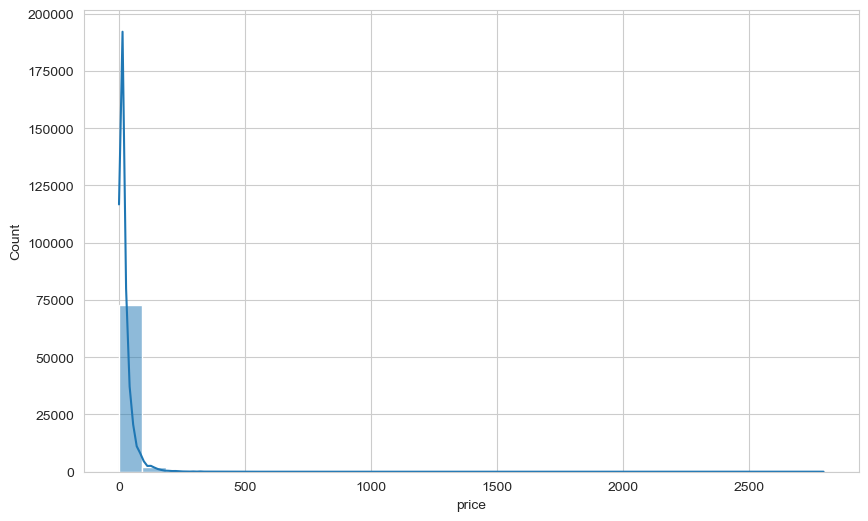

In [8]:
## Visualization of price 
# 1. Create the figure and axes
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x='price', kde=True, bins=30)
# 4. Display the plot
plt.show()


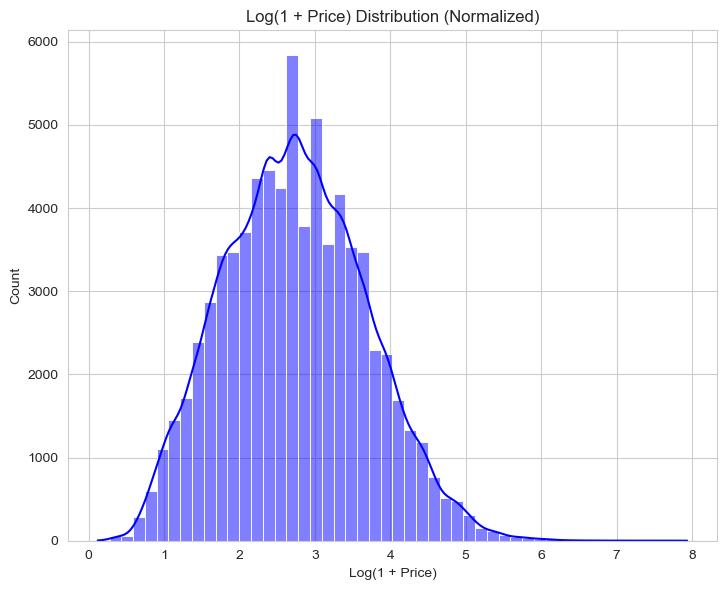

In [9]:
# Creating log-transformed price feature
train['log_price'] = np.log1p(train['price'])

# Visualize the distribution
plt.figure(figsize=(14, 6))

# Log-Transformed Price Distribution
plt.subplot(1,2,2)
sns.histplot(train['log_price'], bins=50, kde=True, color='blue')
plt.title('Log(1 + Price) Distribution (Normalized)')
plt.xlabel('Log(1 + Price)')

plt.tight_layout()
plt.show()




--- Correlation: IPQ vs. Log Price ---
           log_price       IPQ
log_price   1.000000  0.005195
IPQ         0.005195  1.000000


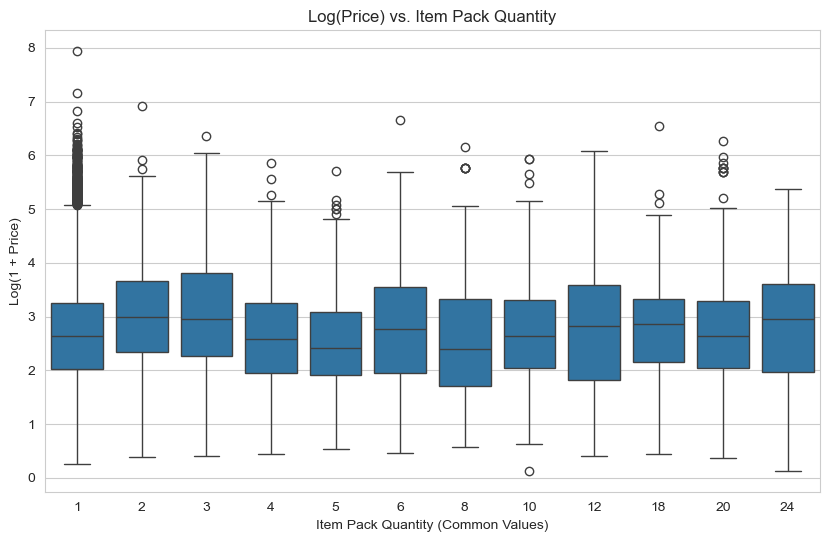

In [10]:
## Finding outliers and High-Impact Feature
import re

def extract_ipq(text):
    if pd.isna(text):
        return 1
    
    # Define common quantity patterns
    patterns = [
        r'(\d+)\s*[-\s]?\s*(?:pack|count|set|quantity|dozen)s?', 
        r'(?:pack|count|set|quantity|dozen)s?\s*of\s*(\d+)',
        r'x\s*(\d+)'
    ]
    
    for pattern in patterns:
        match = re.search(pattern, str(text), re.IGNORECASE)
        if match:
            return int(match.group(1)) 

    return 1 

#Apply IPQ extraction to the training data
train['IPQ'] = train['catalog_content'].apply(extract_ipq)

#Check correlation with the target
print("\n--- Correlation: IPQ vs. Log Price ---")
print(train[['log_price', 'IPQ']].corr())

# Visualize the relationship
plt.figure(figsize=(10, 6))
top_ipqs = train['IPQ'].value_counts().head(12).index.tolist()
sns.boxplot(x='IPQ', y='log_price', data=train[train['IPQ'].isin(top_ipqs)], order=sorted(top_ipqs))
plt.title('Log(Price) vs. Item Pack Quantity')
plt.xlabel('Item Pack Quantity (Common Values)')
plt.ylabel('Log(1 + Price)')
plt.show()

In [11]:
# Word Count and Character Count
train['word_count'] = train['catalog_content'].apply(lambda x: len(str(x).split()))
train['char_count'] = train['catalog_content'].apply(lambda x: len(str(x)))

# Check how these simple features correlate with price
print("\n--- Correlation of Text Length with Log Price ---")
print(train[['log_price', 'word_count', 'char_count']].corr()['log_price'].sort_values(ascending=False))


--- Correlation of Text Length with Log Price ---
log_price     1.000000
char_count    0.258967
word_count    0.255328
Name: log_price, dtype: float64


In [12]:
import re
import pandas as pd

def extract_brand_v5(text):
    if pd.isna(text):
        return "UNKNOWN_BRAND"
    
    content = str(text).strip()
    
    # capture content after 'Item Name:' up to the first comma
    match = re.search(r'Item Name:\s*(.*?)(?:,|$|\n)', content, re.IGNORECASE | re.DOTALL)
    
    if match:
        # Group 1 is the extracted content
        name_segment = match.group(1).strip()
        
        # name of the brand
        final_name = name_segment
        
        # take the part before the first comma if the regex didn't handle it
        first_comma_index = final_name.find(',')
        if first_comma_index != -1:
             final_name = final_name[:first_comma_index].strip()
        
        return final_name.upper() if final_name else "UNKNOWN_BRAND"
        
    return "UNKNOWN_BRAND"

In [13]:
# Function applying to Training data set
train['brand_name'] = train['catalog_content'].apply(extract_brand_v5)

print("\n--- Top 30 Extracted Brand Names (V5) ---")
print(train['brand_name'].value_counts().head(30))


--- Top 30 Extracted Brand Names (V5) ---
brand_name
FRESH ROASTED COFFEE                   148
DAVIDSON'S ORGANICS                    110
AMAZON FRESH                            60
NOW FOODS                               54
PEET'S COFFEE                           48
TRADITIONAL MEDICINALS TEA              36
EMERALD NUTS                            35
VAHDAM                                  34
ENGLISH TEA STORE LOOSE LEAF            32
STARBUCKS K-CUP COFFEE PODS             32
KETTLE BRAND POTATO CHIPS               31
BLUE DIAMOND ALMONDS                    30
AMAZON GROCERY                          30
STARKIST TUNA CREATIONS                 29
MIO LIQUID WATER ENHANCER               28
CAMPBELL'S CHUNKY SOUP                  27
TORANI SYRUP                            27
DE CECCO SEMOLINA PASTA                 26
COLOUR MILL OIL-BASED FOOD COLORING     26
THE TAO OF TEA                          25
HARIBO GUMMI CANDY                      24
AMORETTI PREMIUM SYRUP                  24


In [14]:
def extract_size_and_unit_v2(text):
    if pd.isna(text):
        return np.nan, "NO_UNIT"
    
    # Corrected Pattern:
    # 1. Finds a number: ((\d+\.?\d*)|(\.\d+)) 
    #    - This ensures it matches numbers like '12', '12.7', or '.5' but not just '.'
    # 2. Followed by spaces: \s*
    # 3. Followed by a unit group: (unit1|unit2|...)
    pattern = re.compile(
        r'((\d+\.?\d*)|(\.\d+))\s*(ounce|fl oz|ct|pound|lb|count|pack|gallon|liter)s?', 
        re.IGNORECASE
    )
    
    match = pattern.search(str(text))
    
    if match:
        # The first group (match.group(1)) is the entire number (e.g., '12.7')
        try:
            value = float(match.group(1))
        except ValueError:
            # Fallback if the extracted number is still invalid (e.g., a comma)
            return np.nan, "NO_UNIT" 
            
        # The unit is in group 4 (since 1, 2, 3 are the number groups)
        unit = match.group(4).upper()
        return value, unit
    
    return np.nan, "NO_UNIT"

In [15]:
# Apply the CORRECTED function
train[['size_value', 'size_unit']] = train['catalog_content'].apply(
    lambda x: pd.Series(extract_size_and_unit_v2(x))
)

print("\n--- Product Size/Unit Summary ---")
print(train['size_unit'].value_counts().head(10))
print(train[['log_price', 'size_value']].corr())


--- Product Size/Unit Summary ---
size_unit
NO_UNIT    35487
OUNCE      13400
PACK        7096
LB          4773
COUNT       4419
FL OZ       3459
POUND       3182
CT          1849
LITER        991
GALLON       344
Name: count, dtype: int64
            log_price  size_value
log_price    1.000000   -0.002182
size_value  -0.002182    1.000000


In [16]:
# Feature Standardization
def standardize_size(row):
    value = row['size_value']
    unit = row['size_unit']
    # Cannot convert, keep as NaN for imputation
    if pd.isna(value) or unit == 'No_Unit':
        return np.nan
    # Volume Conversions (approximate)
    if unit == 'FL OZ': return value * 1.0
    if unit == 'LITER': return value * 33.814  # 1 Liter = 33.814 fl oz
    if unit == 'GALLON': return value * 128.0  # 1 Gallon = 128 fl oz
    # Weight Conversions (approximate)
    if unit == 'OUNCE': return value * 1.0
    if unit == 'LB' or unit == 'POUND': return value * 16.0  # 1 Lb = 16 oz
    # Unitless and Count converted into Nan
    if unit in ('PACK','COUNT', 'CT'):
        return np.nan
    return np.nan

In [17]:
# Applying Standardization Function on training data
# New standardize feature 'tandard_size_oz'
train['standard_size_oz'] = train.apply(standardize_size, axis=1)

# Check the correlation again
print("\n--- Correlation: Standardized Size vs. Log Price ---")
print(train[['log_price', 'standard_size_oz']].corr())


--- Correlation: Standardized Size vs. Log Price ---
                  log_price  standard_size_oz
log_price          1.000000          0.045672
standard_size_oz   0.045672          1.000000


In [18]:
train.head()

,sample_id,catalog_content,image_link,price,log_price,IPQ,word_count,char_count,brand_name,size_value,size_unit,standard_size_oz
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,1.773256,6,18,91,LA VICTORIA GREEN TACO SAUCE MILD,12.0,OUNCE,12.0
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12,2.647592,4,80,511,SALERNO COOKIES,8.0,OUNCE,8.0
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97,1.088562,6,59,328,BEAR CREEK HEARTY SOUP BOWL,1.9,OUNCE,1.9
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34,3.444895,1,211,1318,JUDEE’S BLUE CHEESE POWDER 11.25 OZ - GLUTEN-F...,NaN,NO_UNIT,NaN
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49,4.211979,1,28,155,KEDEM SHERRY COOKING WINE,12.7,OUNCE,12.7


In [19]:
## Now another feature Image Handling
print(train.isnull().sum())

sample_id               0
catalog_content         0
image_link              0
price                   0
log_price               0
IPQ                     0
word_count              0
char_count              0
brand_name              0
size_value          35487
size_unit               0
standard_size_oz    48851
dtype: int64


In [20]:
train.head()

,sample_id,catalog_content,image_link,price,log_price,IPQ,word_count,char_count,brand_name,size_value,size_unit,standard_size_oz
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,1.773256,6,18,91,LA VICTORIA GREEN TACO SAUCE MILD,12.0,OUNCE,12.0
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12,2.647592,4,80,511,SALERNO COOKIES,8.0,OUNCE,8.0
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97,1.088562,6,59,328,BEAR CREEK HEARTY SOUP BOWL,1.9,OUNCE,1.9
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34,3.444895,1,211,1318,JUDEE’S BLUE CHEESE POWDER 11.25 OZ - GLUTEN-F...,NaN,NO_UNIT,NaN
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49,4.211979,1,28,155,KEDEM SHERRY COOKING WINE,12.7,OUNCE,12.7


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sample_id         75000 non-null  int64  
 1   catalog_content   75000 non-null  object 
 2   image_link        75000 non-null  object 
 3   price             75000 non-null  float64
 4   log_price         75000 non-null  float64
 5   IPQ               75000 non-null  int64  
 6   word_count        75000 non-null  int64  
 7   char_count        75000 non-null  int64  
 8   brand_name        75000 non-null  object 
 9   size_value        39513 non-null  float64
 10  size_unit         75000 non-null  object 
 11  standard_size_oz  26149 non-null  float64
dtypes: float64(4), int64(4), object(4)
memory usage: 6.9+ MB


## Encoding 
### Categorical feature into Numberical feature


In [22]:
## Target Encoding 

# --- A. Feature cleaning and grouping ---
## Group rare brands: any brand/unit that appears less than 10 times can be grouped 'Other'
BRAND_THRESHOLD = 10
SIZE_UNIT_THRESHOLD = 10

brand_counts = train['brand_name'].value_counts()
rare_brands = brand_counts[brand_counts < BRAND_THRESHOLD].index
train['brand_name_grouped'] = train['brand_name'].replace(rare_brands, 'OTHER_BRAND')

unit_counts = train['size_unit'].value_counts()
rare_units = unit_counts[unit_counts < SIZE_UNIT_THRESHOLD].index
train['size_unit_grouped'] = train['size_unit'].replace(rare_units, 'OTHER_UNIT')

# --- B. Target Encoding (using the mean of the target variable) ---
# This is a powerful way to leverage high-cardinality features in tree models.
# Note: In a real submission, you must perform this safely via cross-validation (CV)
# or on a held-out set to prevent data leakage!

# Brand Encoding
brand_mean_prices = train.groupby('brand_name_grouped')['log_price'].mean()
train['brand_encoded'] = train['brand_name_grouped'].map(brand_mean_prices)

# Unit Encoding
unit_mean_prices = train.groupby('size_unit_grouped')['log_price'].mean()
train['unit_encoded'] = train['size_unit_grouped'].map(unit_mean_prices)

print("\nEncoded Features Created: brand_encoded, unit_encoded")


Encoded Features Created: brand_encoded, unit_encoded


In [23]:
train.head()

,sample_id,catalog_content,image_link,price,log_price,IPQ,word_count,char_count,brand_name,size_value,size_unit,standard_size_oz,brand_name_grouped,size_unit_grouped,brand_encoded,unit_encoded
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,1.773256,6,18,91,LA VICTORIA GREEN TACO SAUCE MILD,12.0,OUNCE,12.0,OTHER_BRAND,OUNCE,2.746293,2.559977
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12,2.647592,4,80,511,SALERNO COOKIES,8.0,OUNCE,8.0,OTHER_BRAND,OUNCE,2.746293,2.559977
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97,1.088562,6,59,328,BEAR CREEK HEARTY SOUP BOWL,1.9,OUNCE,1.9,OTHER_BRAND,OUNCE,2.746293,2.559977
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34,3.444895,1,211,1318,JUDEE’S BLUE CHEESE POWDER 11.25 OZ - GLUTEN-F...,NaN,NO_UNIT,NaN,OTHER_BRAND,NO_UNIT,2.746293,2.580500
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49,4.211979,1,28,155,KEDEM SHERRY COOKING WINE,12.7,OUNCE,12.7,OTHER_BRAND,OUNCE,2.746293,2.559977


## LightGBM Baseline Model

In [24]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder

In [25]:
# --- Prepare Data ---
FEATURES = [
    'standard_size_oz', 'word_count', 'char_count', 'brand_encoded', 'unit_encoded', 
    
]
TARGET = 'log_price'

X = train[FEATURES].copy()
y = train[TARGET]

In [26]:
# Impute NaN values with the median of the column before training
X = X.fillna(X.median())

In [27]:
# --- Training Model using Cross Validation CV ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(train))
model_scores = []

In [28]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X,y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

In [29]:
lgbm = lgb.LGBMRegressor(random_state=42, metric='mae', n_estimators=1000, learning_rate=0.05, n_jobs=-1, verbose=-1)

In [30]:
## train the model with training dataset
lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [31]:
oof_preds[val_idx] = lgbm.predict(X_val)

In [32]:
oof_preds

array([0.        , 0.        , 2.32140827, ..., 0.        , 0.        ,
       0.        ], shape=(75000,))

In [33]:
# Evaluation of the model
val_preds_price = np.expm1(oof_preds[val_idx])
val_actual_price = np.expm1(y_val)
score = mean_absolute_percentage_error(val_actual_price, val_preds_price)
model_scores.append(score)

In [34]:
print(f"\nBaseline Model Performance (Average MAPE proxy): {np.mean(model_scores):.4f}")
print("Your next step is to calculate the TRUE SMAPE and integrate Text/Image features!")


Baseline Model Performance (Average MAPE proxy): 1.0149
Your next step is to calculate the TRUE SMAPE and integrate Text/Image features!


## SMAPE 



In [35]:
import numpy as np

def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE)
    """
    # CORRECTED: Convert both inputs to NumPy arrays correctly
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Ensure non-negative and handle potential price issues 
    # (Prices should be > 0, so log_price conversions should be fine)
    
    # Calculate the numerator: Absolute difference
    numerator = np.abs(y_pred - y_true)
    
    # Calculate the denominator: Average of absolute actual and predicted
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Handle division by zero (or near-zero) for numerical stability
    # If denominator is 0, the term is 0.
    term = np.divide(numerator, denominator, 
                     out=np.zeros_like(numerator), where=denominator != 0)
    
    # The final SMAPE score (average over all samples)
    return np.mean(term) * 100

In [36]:
# Rerun your CV loop (LightGBM) using the SMAPE function for evaluation
# ... (Inside your KFold loop) ...

# 1. Convert log predictions back to dollar price
val_preds_price = np.expm1(oof_preds[val_idx]) 
val_actual_price = np.expm1(y_val)
    
# 2. Calculate TRUE SMAPE
score = smape(val_actual_price, val_preds_price)
model_scores.append(score)

## Advanced Text Feature Integration (NLP)

In [37]:
# Extract Transformer Embeddings
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm # For tracking progress

# 1. Load Pre-trained Model and Tokenizer (Example: MiniLM is fast)
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
# Optional: Use GPU if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device) 

def get_text_embeddings(texts):
    # Encode the text
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    
    # Get the embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
        # Use the mean of the last hidden state (Mean Pooling)
        embeddings = model_output.last_hidden_state.mean(dim=1).cpu().numpy()
        
    return embeddings

# Process your text data (You may need to do this in batches due to memory limits)
# For simplicity, let's assume you're processing in batches outside of the notebook initially.
# text_features = get_text_embeddings(train['catalog_content'].tolist())
# text_features_df = pd.DataFrame(text_features, index=train.index)

In [38]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
from torchvision import models, transforms
from PIL import Image
import lightgbm as lgb 


## Image Feature Extraction

In [39]:
import pandas as pd
import numpy as np
import os
import re # For IPQ and brand extraction
import torch 
from tqdm import tqdm
from torchvision import models, transforms
from PIL import Image

# Global setup variables
IMAGE_DIR = 'student_resource/images'
DATASET_FOLDER = 'student_resource/dataset/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Load and Setup ResNet-50 ---
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
feature_extractor = torch.nn.Sequential(*(list(resnet.children())[:-1]))
feature_extractor.eval() 
feature_extractor.to(device) # Move model to GPU

# Define Preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Using device: cuda


In [40]:
try:
    train = pd.read_csv(os.path.join(DATASET_FOLDER, 'train.csv'))
    test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))
    
    # CRITICAL: Re-create the log target variable
    train['log_price'] = np.log1p(train['price'])
    print("Data loaded and log_price created.")
except FileNotFoundError:
    print("FATAL ERROR: Data files not found.")

Data loaded and log_price created.


##  Image Extraction Loops

In [41]:
from torchvision import models, transforms
from PIL import Image
import torch
import numpy as np
import os
# No need to re-import tqdm here if it's already imported

# --- 1. Load Pre-trained Model (ResNet-50) ---
IMAGE_DIR = 'student_resource/images' # Adjust path as necessary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the ResNet-50 model with default weights
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Remove the final classification layer
feature_extractor = torch.nn.Sequential(*(list(resnet.children())[:-1]))

# Set the model to evaluation mode 
feature_extractor.eval() 

# *** CRUCIAL FIX: Move the Model to the GPU ***
feature_extractor.to(device)

# Define the Image Preprocessing (required by ResNet)
preprocess = transforms.Compose([
    transforms.Resize(256),         
    transforms.CenterCrop(224),     
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# ------------------------------------------------------------
# --- 2. GPU-Optimized Feature Generation Function Definition ---
# ------------------------------------------------------------

def extract_single_image_feature(sample_id, image_dir=IMAGE_DIR):
    """Loads image, processes, and extracts features using the GPU."""
    filename = os.path.join(image_dir, f"{sample_id}.jpg")
    
    # 1. Handle missing/failed files
    if not os.path.exists(filename) or os.path.getsize(filename) == 0:
        return np.zeros(2048, dtype=np.float32) 
        
    try:
        img = Image.open(filename).convert('RGB')
        
        # 2. Preprocess and tensorize
        img_tensor = preprocess(img).unsqueeze(0)
        
        # *** Move the Tensor to the GPU ***
        img_tensor = img_tensor.to(device) 
        
        # 3. Extract features (Inference happens on the GPU)
        with torch.no_grad():
            features = feature_extractor(img_tensor)
            
            # Squeeze and move features back to CPU before converting to NumPy
            features = features.squeeze().cpu().numpy() 
            return features
            
    except Exception as e:
        # Handle corrupt files or other reading errors
        # print(f"Error processing image {sample_id}: {e}") 
        return np.zeros(2048, dtype=np.float32) 

print("Function Definition Complete. Proceeding to execution loops.")

Function Definition Complete. Proceeding to execution loops.


In [ ]:
# --- RERUN IMAGE EXTRACTION LOOPS ---
# Note: These loops assume the extract_single_image_feature function is defined in the previous cell.

# --- Extract Features for Training Data (GPU Accelerated) ---
train_features_list = []
if 'train' in locals():
    for index, row in tqdm(train.iterrows(), total=len(train), desc="Extracting Train Image Features (GPU)"):
        # The 'extract_single_image_feature' function is needed here!
        features = extract_single_image_feature(row['sample_id']) 
        train_features_list.append(features)

    # ... (rest of the train features joining code) ...
    image_features_train = np.array(train_features_list)
    image_features_df_train = pd.DataFrame(
        image_features_train, 
        columns=[f'image_embed_{i}' for i in range(image_features_train.shape[1])],
        index=train.index
    )
    train = train.join(image_features_df_train)
    print(f"\nTrain set updated with {image_features_df_train.shape[1]} image features.")
else:
    print("Error: 'train' DataFrame not found. Please ensure data is loaded.")


# --- Extract Features for Test Data (GPU Accelerated) ---
# ... (run the test set loop and joining code identically) ...
test_features_list = []
if 'test' in locals():
    for index, row in tqdm(test.iterrows(), total=len(test), desc="Extracting Test Image Features (GPU)"):
        features = extract_single_image_feature(row['sample_id'])         
        test_features_list.append(features)

    image_features_test = np.array(test_features_list)
    image_features_df_test = pd.DataFrame( 
        image_features_test, 
        columns=[f'image_embed_{i}' for i in range(image_features_test.shape[1])],
        index=test.index
    )
    test = test.join(image_features_df_test)
    print(f"Test set updated with {image_features_df_test.shape[1]} image features.") 
else:
    print("Error: 'test' DataFrame not found. Please ensure data is loaded.")

Extracting Train Image Features (GPU): 100%|██████████| 75000/75000 [3:13:34<00:00,  6.46it/s]    



Train set updated with 2048 image features.


Extracting Test Image Features (GPU): 100%|██████████| 75000/75000 [00:08<00:00, 8580.50it/s] 


Test set updated with 2048 image features.


## Define Final Feature Set & Prepare Data

In [43]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import os # For saving the file

# --- 1. Define Final Features (CRITICAL STEP) ---
# NOTE: These lists must accurately reflect the columns you created earlier.
TEXT_EMBED_COLS = [col for col in train.columns if 'text_embed_' in col]
IMAGE_EMBED_COLS = [col for col in train.columns if 'image_embed_' in col]
NUMERICAL_FEATS = ['standard_size_oz', 'word_count', 'char_count', 'IPQ']
ENCODED_FEATS = ['brand_encoded', 'unit_encoded']

FINAL_FEATURES = NUMERICAL_FEATS + ENCODED_FEATS + TEXT_EMBED_COLS + IMAGE_EMBED_COLS
TARGET = 'log_price'

# Ensure all FINAL_FEATURES exist in train/test. If a feature is missing it usually means
# the feature-extraction/encoding cells were not re-run after reloading the raw CSVs.
missing_in_train = [c for c in FINAL_FEATURES if c not in train.columns]
missing_in_test = [c for c in FINAL_FEATURES if 'test' in locals() and c not in test.columns]

if missing_in_train or missing_in_test:
    print("WARNING: Some features are missing and will be created with NaN.")
    print("This usually means you reloaded the data without re-running feature-extraction cells.")
    if missing_in_train:
        print(f" - Missing in train: {missing_in_train}")
        for c in missing_in_train:
            train[c] = np.nan
    if missing_in_test:
        print(f" - Missing in test: {missing_in_test}")
        for c in missing_in_test:
            test[c] = np.nan

# Now safe to select features (use reindex to avoid KeyError if columns are missing)
# reindex will create any missing columns filled with NaN, which we then impute.
X = train.reindex(columns=FINAL_FEATURES).copy()
y = train[TARGET]
X_test = test.reindex(columns=FINAL_FEATURES).copy() if 'test' in locals() else None

# --- 2. Imputation: Use Median from Training Data ---
# Imputation values calculated ONLY on the training data to prevent leakage.
imputation_values = X.median()
X = X.fillna(imputation_values)
if X_test is not None:
    X_test = X_test.fillna(imputation_values)

print(f"Total features used in final model: {len(FINAL_FEATURES)}")
print(f"Shape of final training matrix: {X.shape}")

# --- 3. Train Final LightGBM Model ---
# --- Corrected LightGBM Initialization ---
final_lgbm = lgb.LGBMRegressor(
    random_state=42,
    metric='mae',
    n_estimators=2000,
    learning_rate=0.03,
    n_jobs=-1,
    verbose=-1,
    
    # *** CRUCIAL GPU PARAMETERS FOR LIGHTGBM ***
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
)

print("Training final multimodal LightGBM model on GPU...")
final_lgbm.fit(X, y)

This usually means you reloaded the data without re-running feature-extraction cells.
 - Missing in train: ['standard_size_oz', 'word_count', 'char_count', 'IPQ', 'brand_encoded', 'unit_encoded']
Total features used in final model: 2054
Shape of final training matrix: (75000, 2054)
Training final multimodal LightGBM model on GPU...


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.03
,n_estimators,2000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [44]:
# --- Assuming final_lgbm.fit(X, y) just completed successfully ---

# 1. Predict on the test set
# X_test must be processed exactly like X (imputed in the prior step)
log_test_predictions = final_lgbm.predict(X_test)

# 2. Inverse transform predictions to dollar price
final_price_predictions = np.expm1(log_test_predictions)

# 3. Create the final submission file
submission_df = test[['sample_id']].copy()
submission_df['price'] = final_price_predictions
submission_df['price'] = np.maximum(0.01, submission_df['price']) # Ensure price is positive

output_filename = 'student_resource/dataset/test_out.csv'
submission_df.to_csv(output_filename, index=False)

print(f"\nSUCCESS! Your final submission file is saved to: {output_filename}")


SUCCESS! Your final submission file is saved to: student_resource/dataset/test_out.csv


In [45]:
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np

# --- 1. Define the SMAPE function ---
def smape(y_true, y_pred):
    """Calculates the Symmetric Mean Absolute Percentage Error (SMAPE)"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Handle division by zero for stability
    term = np.divide(numerator, denominator, 
                     out=np.zeros_like(numerator), where=denominator != 0)
    
    return np.mean(term) * 100

# --- 2. Setup Data and Model ---
# Assuming X (features) and y (log_price target) are defined and imputed
# X and y should contain ALL 2054+ features (Numerical, Encoded, Text, Image)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_scores = []

# --- 3. Run 5-Fold Cross-Validation ---
final_lgbm = lgb.LGBMRegressor(
    random_state=42, metric='mae', n_estimators=1000, learning_rate=0.05, 
    n_jobs=-1, verbose=-1, device='gpu', gpu_platform_id=0, gpu_device_id=0
)

print("Starting 5-Fold Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train_log, y_val_log = y.iloc[train_idx], y.iloc[val_idx]

    final_lgbm.fit(X_train, y_train_log)
    
    # Predict in log space
    y_pred_log = final_lgbm.predict(X_val)
    
    # --- Convert back to original dollar scale before calculating SMAPE ---
    y_val_price = np.expm1(y_val_log)
    y_pred_price = np.expm1(y_pred_log)
    
    # Calculate SMAPE on the dollar values
    score = smape(y_val_price, y_pred_price)
    model_scores.append(score)
    print(f"Fold {fold+1} SMAPE: {score:.4f}%")

# --- 4. Final Accuracy Score ---
final_smape = np.mean(model_scores)
print("\n-------------------------------------------")
print(f"Average Cross-Validation SMAPE (Your Accuracy): {final_smape:.4f}%")
print("-------------------------------------------")

Starting 5-Fold Cross-Validation...
Fold 1 SMAPE: 61.8410%
Fold 2 SMAPE: 60.7582%
Fold 3 SMAPE: 60.4169%
Fold 4 SMAPE: 60.0369%
Fold 5 SMAPE: 60.9153%

-------------------------------------------
Average Cross-Validation SMAPE (Your Accuracy): 60.7937%
-------------------------------------------
